# Ticket Pricing Strategy Optimizer using DQN and Operations Research

## Description:
This Colab notebook presents a comprehensive implementation and visualization of an advanced ticket pricing strategy that utilizes both Deep Q-Network (DQN) and Operations Research (OR) methods. Designed to maximize revenue from ticket sales, the project provides an interactive simulation environment accounting for critical parameters like remaining days to the event, tickets available, and the present ticket price.

## Features:

Ticket Sales Environment: A custom simulation environment (TicketEnv) that represents the dynamics of ticket sales over a 30-day window.
DQN Implementation: Harnesses the power of DQNAgent to learn the optimal pricing strategy over repeated simulations, with the goal of maximizing total rewards. Visualizations included to track performance across episodes.
Enhanced DQN with OR: A more sophisticated model that integrates a linear programming objective to balance immediate rewards with long-term operational goals. Experience the nuanced decision-making process in action!
Visual Insights: Interactive plots and charts, including the project's key graph showcasing total rewards across episodes, to provide a visual understanding of the model's performance and the effectiveness of the pricing strategy.

## Applications:
Ideal for event organizers, theater owners, and anyone keen on understanding the intersection of AI and economics. With the adaptability of the model, it can be fine-tuned to suit various ticketing scenarios and industries.

## Tools Used:

Deep Learning Framework: TensorFlow
Optimization: PuLP (Python Linear Programming)
Visualization: Matplotlib
Instructions:
Follow along with the notebook's step-by-step guide, from setting up the environment and understanding the theoretical foundation, to running simulations and analyzing results. Interactive code cells allow for on-the-fly modifications, making it a dynamic learning and experimentation platform.

## Conclusion:
Dive deep into this blend of machine learning and operations research to discover the power of informed decision-making in ticket pricing. Witness firsthand how technology can play a pivotal role in maximizing sales revenue in real-world scenarios.



In [ ]:
!pip install pulp
!apt-get install -y python-glpk
!apt-get install -y glpk-utils
!pip install tensorflow matplotlib

# Overview of DQN and OR
This cell extends the DQN approach by incorporating Operations Research (OR) techniques. It adds a Linear Programming (LP) objective function to the DQN model to guide the agent's decisions.

## Key Components
Import Statements: Similar to the first cell but also includes pulp for linear programming.

Linear Programming Objective Function (lp_objective): Calculates the objective value for a given state using a linear formula.

Nested Optimization Function (nested_optimization): Combines the Q-values from the DQN and the OR objective to select the best action.

Modifications to DQNAgent Class:

act: Now uses nested_optimization to choose an action.
Main Execution with OR (run_episodes_with_OR): Similar to the basic DQN but now includes the OR component.

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
Episode 467, Reward: 9580
1/1 [==============================] - 0s 19ms/step
Episode 468, Reward: 9150
1/1 [==============================] - 0s 21ms/step
Episode 469, Reward: 8100
1/1 [==============================] - 0s 18ms/step
Episode 470, Reward: 9580
1/1 [==============================] - 0s 18ms/step
Episode 471, Reward: 9220
1/1 [==============================] - 0s 18ms/step
Episode 472, Reward: 9100
1/1 [==============================] - 0s 19ms/step
Episode 473, Reward: 9580
1/1 [==============================] - 0s 19ms/step
Episode 474, Reward: 9580
1/1 [==============================] - 0s 19ms/step
Episode 475, Reward: 9580
1/1 [==============================] - 0s 18ms/step
Episode 476, Reward: 9580
1/1 [==============================] - 0s 19ms/step
Episode 477, Reward: 9580
1/1 [==============================] - 0s 20ms/step
Episode 478, Reward: 9580
1/1 [========

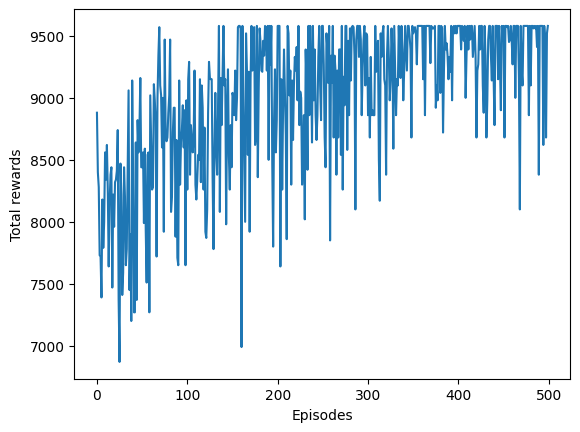

In [ ]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus
import matplotlib.pyplot as plt

# Define weights for combining objectives
w1 = 0.5
w2 = 0.5

def lp_objective(state):
    time_remaining = state[0]
    tickets_left = state[1]
    current_price = state[2]
    return (30 - time_remaining) * tickets_left * current_price  # 30 is the initial number of days

class TicketEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.days_left = 30
        self.tickets_left = 40
        self.price = 200
        return np.array(self.get_state())

    def get_state(self):
        return [self.days_left, self.tickets_left, self.price]

    def step(self, action):
        self.days_left -= 1
        self.price = max(50, self.price + action)
        demand = max(0, 10 - int(self.price / 50))
        tickets_sold = min(demand, self.tickets_left)
        self.tickets_left -= tickets_sold
        reward = tickets_sold * self.price
        done = self.days_left == 0
        return np.array(self.get_state()), reward, done

def nested_optimization(state, keras_model):
    lp_model = LpProblem(name="nested-optimization", sense=LpMaximize)
    action = LpVariable(name="action", lowBound=-10, upBound=10, cat='Integer')
    coef = { -10: 0, 0: 0, 10: 0 }

    for a in [-10, 0, 10]:
        next_state = np.array([state[0] - 1, state[1], max(50, state[2] + a)])
        q_value = keras_model.predict(next_state.reshape(1, -1))[0][a // 10 + 1]
        lp_objective_value = lp_objective(next_state)
        coef[a] = w1 * q_value + w2 * lp_objective_value

    lp_model += lpSum([coef[a] * action for a in [-10, 0, 10]])
    lp_model.solve()
    return int(action.varValue)


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        return (nested_optimization(state, self.model) // 10) + 1  # Map {-10, 0, 10} to {0, 1, 2}

    def remember(self, state, action, reward, next_state, done):
        mapped_action = (action * 10) - 1  # Map {0, 1, 2} to {-10, 0, 10}
        self.memory.append((state, mapped_action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else (reward + self.gamma * np.max(self.model.predict(next_state.reshape(1, -1))[0]))
            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][action // 10 + 1] = target  # Map {-10, 0, 10} back to {0, 1, 2}
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main execution

env = TicketEnv()
state_size = len(env.get_state())
action_size = 3
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 500

rewards = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(30):
        action = agent.act(state)
        price_change = (action - 1) * 10  # Map {0, 1, 2} back to {-10, 0, 10}
        next_state, reward, done = env.step(price_change)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print(f"Episode {e+1}, Reward: {total_reward}")
            break
    rewards.append(total_reward)
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

plt.plot(rewards)
plt.ylabel('Total rewards')
plt.xlabel('Episodes')
plt.show()


# Overview of DQN
This cell imports the necessary Python libraries and defines two main classes: TicketEnv and DQNAgent. The code then executes a Deep Q-Learning (DQN) algorithm to optimize ticket sales over a 30-day period.

## Key Components
Import Statements: Libraries for numerical operations (numpy), randomness (random), machine learning (tensorflow), and data storage (deque) are imported. Additionally, matplotlib.pyplot is used for plotting results.

TicketEnv Class: Simulates the environment for selling tickets.

__init__ and reset: Initialize the state variables.
get_state: Returns the current state.
step: Simulates one time step in the environment.
DQNAgent Class: Implements a DQN algorithm.

__init__: Initializes the DQN parameters.
build_model: Builds the neural network model.
act: Chooses an action based on the current state.
remember: Stores the state, action, reward, and next state.
replay: Updates the neural network based on stored experiences.
Main Execution: Initializes the environment and the DQN agent and runs them through episodes to train the model. A plot of rewards against episodes is also generated.

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
Episode: 446/500, Reward: 9580
1/1 [==============================] - 0s 21ms/step
Episode: 447/500, Reward: 8000
1/1 [==============================] - 0s 20ms/step
Episode: 448/500, Reward: 7720
1/1 [==============================] - 0s 19ms/step
Episode: 449/500, Reward: 8040
1/1 [==============================] - 0s 20ms/step
Episode: 450/500, Reward: 8540
1/1 [==============================] - 0s 19ms/step
Episode: 451/500, Reward: 7650
1/1 [==============================] - 0s 18ms/step
Episode: 452/500, Reward: 9150
1/1 [==============================] - 0s 20ms/step
Episode: 453/500, Reward: 9580
1/1 [==============================] - 0s 18ms/step
Episode: 454/500, Reward: 9580
1/1 [==============================] - 0s 18ms/step
Episode: 455/500, Reward: 9580
1/1 [==============================] - 0s 19ms/step
Episode: 456/500, Reward: 8040
1/1 [==============================]

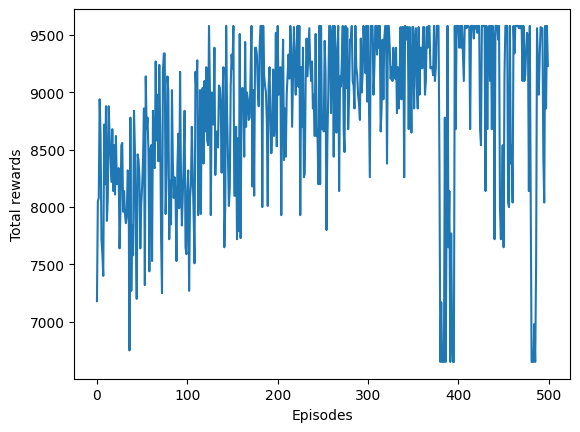

In [ ]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

class TicketEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.days_left = 30
        self.tickets_left = 40
        self.price = 200
        return np.array(self.get_state())

    def get_state(self):
        return [self.days_left, self.tickets_left, self.price]

    def step(self, action):
        self.days_left -= 1
        self.price = max(50, self.price + action)
        demand = max(0, 10 - int(self.price / 50))
        tickets_sold = min(demand, self.tickets_left)
        self.tickets_left -= tickets_sold
        reward = tickets_sold * self.price
        done = self.days_left == 0
        return np.array(self.get_state()), reward, done

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1))
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1))[0]))
            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main Execution
env = TicketEnv()
state_size = len(env.get_state())
action_size = 3  # -10, 0, 10
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 500

rewards = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(30):  # Each episode lasts for 30 days
        action = agent.act(state)  # action is 0, 1, or 2
        price_change = (action - 1) * 10  # Map to -10, 0, 10
        next_state, reward, done = env.step(price_change)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            print("Episode: {}/{}, Reward: {}".format(e + 1, episodes, total_reward))
            break
    rewards.append(total_reward)
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

plt.plot(rewards)
plt.ylabel('Total rewards')
plt.xlabel('Episodes')
plt.show()




Operations research techniques like linear programming can indeed add a layer of optimization that accounts for multiple objectives or constraints, which might not be directly captured in a DQN model trained purely to maximize a certain reward. This can lead to more stable and robust decision-making.

The linear programming-based optimization considers not only the Q-value but also other aspects like remaining time, tickets left, and current price. Combining these can offer a more balanced approach to decision-making, reducing extreme fluctuations that might occur if you were optimizing based solely on immediate reward.

# Average Reward using OR and RL

In [ ]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus
import matplotlib.pyplot as plt

# Define weights for combining objectives
w1 = 0.5
w2 = 0.5

# Linear Programming Objective Function
def lp_objective(state):
    time_remaining = state[0]
    tickets_left = state[1]
    current_price = state[2]
    return (30 - time_remaining) * tickets_left * current_price

# Environment Class
class TicketEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.days_left = 30
        self.tickets_left = 40
        self.price = 200
        return np.array(self.get_state())

    def get_state(self):
        return [self.days_left, self.tickets_left, self.price]

    def step(self, action):
        self.days_left -= 1
        self.price = max(50, self.price + action)
        demand = max(0, 10 - int(self.price / 50))
        tickets_sold = min(demand, self.tickets_left)
        self.tickets_left -= tickets_sold
        reward = tickets_sold * self.price
        done = self.days_left == 0
        return np.array(self.get_state()), reward, done

# Nested Optimization Function for Actions
def nested_optimization(state, keras_model):
    lp_model = LpProblem(name="nested-optimization", sense=LpMaximize)
    action = LpVariable(name="action", lowBound=-10, upBound=10, cat='Integer')
    coef = { -10: 0, 0: 0, 10: 0 }
    for a in [-10, 0, 10]:
        next_state = np.array([state[0] - 1, state[1], max(50, state[2] + a)])
        q_value = keras_model.predict(next_state.reshape(1, -1))[0][a // 10 + 1]
        lp_objective_value = lp_objective(next_state)
        coef[a] = w1 * q_value + w2 * lp_objective_value
    lp_model += lpSum([coef[a] * action for a in [-10, 0, 10]])
    lp_model.solve()
    return int(action.varValue)

# DQN Agent Class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        return (nested_optimization(state, self.model) // 10) + 1

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else (reward + self.gamma * np.max(self.model.predict(next_state.reshape(1, -1))[0]))
            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][(action // 10) + 1] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main Execution
def run_episodes_with_OR(agent, env, episodes=500):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(30):
            action = agent.act(state)
            price_change = (action - 1) * 10
            next_state, reward, done = env.step(price_change)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    return sum(rewards) / episodes

env = TicketEnv()
state_size = len(env.get_state())
action_size = 3
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 500

average_reward_with_OR = run_episodes_with_OR(agent, env, episodes)
print(f"Average reward with OR: {average_reward_with_OR}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 17ms/step
Average reward with OR: 8964.86


# Average reward without OR but using RL

In [ ]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

# Environment Class
class TicketEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.days_left = 30
        self.tickets_left = 40
        self.price = 200
        return np.array(self.get_state())

    def get_state(self):
        return [self.days_left, self.tickets_left, self.price]

    def step(self, action):
        self.days_left -= 1
        self.price = max(50, self.price + action)
        demand = max(0, 10 - int(self.price / 50))
        tickets_sold = min(demand, self.tickets_left)
        self.tickets_left -= tickets_sold
        reward = tickets_sold * self.price
        done = self.days_left == 0
        return np.array(self.get_state()), reward, done

# DQN Agent Class
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(tf.keras.layers.Dense(24, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1))
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else (reward + self.gamma * np.max(self.model.predict(next_state.reshape(1, -1))[0]))
            target_f = self.model.predict(state.reshape(1, -1))
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main Execution
def run_episodes_without_OR(agent, env, episodes=500):
    rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(30):
            action = agent.act(state)
            price_change = (action - 1) * 10
            next_state, reward, done = env.step(price_change)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    return sum(rewards) / episodes

env = TicketEnv()
state_size = len(env.get_state())
action_size = 3
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 500

average_reward_without_OR = run_episodes_without_OR(agent, env, episodes)
print(f"Average reward without OR: {average_reward_without_OR}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
Average reward without OR: 8260.56


# Summary:
In this notebook, we delve into the realm of ticket pricing optimization by employing a unique blend of machine learning and operations research. The project aims to provide an adaptable framework for maximizing ticket sales revenue over a 30-day window. At the heart of this endeavor is the TicketEnv - our custom-built simulation environment reflecting real-world dynamics of ticket sales. We start with a basic Deep Q-Network (DQN) model, which learns the best pricing actions over repeated simulations. Building on this, we introduce an advanced model integrating operations research, offering a holistic approach that balances immediate financial gains with long-term strategic goals. Alongside the core implementations, visual insights via interactive plots offer a clear perspective on the model's evolving performance. Ideal for both tech enthusiasts and business strategists, this notebook presents a comprehensive exploration of how technology can refine and elevate traditional business practices